## Conjunto de librerías

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from sklearn.linear_model import LinearRegression
from random import seed
seed(1) ### Para no variar los aleatorios
%matplotlib inline
%reload_ext rpy2.ipython

## Lectura de datos

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ANN-2019-2/evaluacion-cdbolivarz/master/datos/diabetes.csv",
    sep = ',',         # separador de campos
    thousands = None,  # separador de miles para números
    decimal = '.')     # separador de los decimales para números

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


## Análisis exploriatorio
Todas las columnas son numéricas, pero no estan normalizadas.

In [0]:
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634599e-16,1.296411e-16,-8.042209e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.575274e-16,3.780755e-16,-3.830854e-16,-3.411950e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


### Normalización y transformaciones

In [0]:
transf_list = ['r', 'f', 'g', 'h', 'i', 'j', 'k', 'n']
def transf(name, X):
  X = np.array(X);
  if name == 'f':
    return np.log(X + 1)
  elif name == 'g':
    return np.divide(1, np.log(X + 1))
  elif name == 'h':
    return np.sqrt(X + 10)
  elif name == 'i':
    return np.power(X, 2)
  elif name == 'j':
    return np.divide(1, X + 1)
  elif name == 'k':
    return np.exp(X/(X + 1))
  elif name == 'n':
    return np.power(X + 10, 1/4)
  return X

def inv_transf(name, X):
  X = np.array(X)
  if name == 'f':
    return np.exp(X)-1
  elif name == 'g':
    return np.exp(np.divide(1,X)) - 1
  elif name == 'h':
    return np.power(X,2) - 10
  elif name == 'i':
    return np.sqrt(np.abs(X))
  elif name == 'j':
    return np.divide(1, X) - 1
  elif name == 'k':
    return np.divide(1, 1 - np.log(X)) - 1
  elif name == 'n':
    return np.power(X,4) - 10
  return X

In [0]:
def scaler(X):
  max_value = X.max() # Maximo de cada columna
  min_value = X.min() # Minimo de cada columna
  return (X - min_value)/(max_value - min_value)

#Solo para Y i
def des_scaler(Y):
  max_value = df_norm_Y['Y i'].max()
  min_value = df_norm_Y['Y i'].min()
  return Y*(max_value - min_value) + min_value

In [0]:
def norm():
  df_norm = pd.DataFrame()
  for column in df:
    if column != 'Y':
      for trans in transf_list:
        df_norm[column + " " + trans] = scaler(transf(trans, df[column])) # Se anade a cada columna la transformacion
  return df_norm

def norm_Y():
  df_norm_Y = pd.DataFrame()
  for trans in transf_list:
    df_norm_Y["Y " + trans] = transf(trans, df['Y']) # Se anade a cada columna la transformacion
  return df_norm_Y
df_norm = norm()
df_norm_Y = norm_Y()

In [0]:
df_norm.head()

,age r,age f,age g,age h,age i,age j,age k,age n,sex r,sex f,sex g,sex h,sex i,sex j,sex k,sex n,bmi r,bmi f,bmi g,bmi h,bmi i,bmi j,bmi k,bmi n,bp r,bp f,bp g,bp h,bp i,bp j,bp k,bp n,s1 r,s1 f,s1 g,s1 h,s1 i,s1 j,s1 k,s1 n,s2 r,s2 f,s2 g,s2 h,s2 i,s2 j,s2 k,s2 n,s3 r,s3 f,s3 g,s3 h,s3 i,s3 j,s3 k,s3 n,s4 r,s4 f,s4 g,s4 h,s4 i,s4 j,s4 k,s4 n,s5 r,s5 f,s5 g,s5 h,s5 i,s5 j,s5 k,s5 n,s6 r,s6 f,s6 g,s6 h,s6 i,s6 j,s6 k,s6 n
0,0.666667,0.690318,0.505717,0.667875,0.118028,0.286676,0.690519,0.668479,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.582645,0.612798,0.245286,0.584222,0.130852,0.357615,0.613956,0.585011,0.549296,0.579096,0.061728,0.550806,0.027438,0.391483,0.579320,0.551561,0.294118,0.324106,0.855977,0.295577,0.082555,0.644910,0.323669,0.296307,0.256972,0.287401,0.802883,0.258472,0.030683,0.680831,0.287574,0.259224,0.207792,0.231585,0.197392,0.208959,0.057365,0.743425,0.231658,0.209544,0.282087,0.308225,0.138808,0.283409,0.000192,0.664791,0.308956,0.284070,0.562217,0.593808,0.317680,0.563813,0.022202,0.375112,0.593871,0.564611,0.439394,0.473586,0.694638,0.441079,0.016346,0.492056,0.473084,0.441922
1,0.483333,0.510619,0.000000,0.484694,0.000039,0.462137,0.510499,0.485374,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.148760,0.165682,0.238240,0.149587,0.091083,0.816418,0.165714,0.150001,0.352113,0.380472,0.056410,0.353508,0.039755,0.590615,0.380225,0.354206,0.421569,0.455943,0.840089,0.423279,0.003012,0.509401,0.455876,0.424135,0.306773,0.340305,0.801727,0.308443,0.009293,0.625059,0.340679,0.309279,0.623377,0.654788,0.219787,0.625031,0.168665,0.314677,0.656057,0.625858,0.141044,0.157074,0.236889,0.141836,0.045454,0.825957,0.157322,0.142232,0.222443,0.246018,0.305500,0.223570,0.261582,0.729345,0.245328,0.224134,0.166667,0.186979,0.731178,0.167620,0.447894,0.791508,0.186104,0.168098
2,0.883333,0.893978,0.492527,0.883892,0.593346,0.095971,0.894216,0.884171,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.516529,0.547836,0.246530,0.518151,0.067924,0.421107,0.548882,0.518961,0.436620,0.466774,0.047619,0.438123,0.001844,0.502908,0.466728,0.438874,0.289216,0.318937,0.856090,0.290661,0.087772,0.650325,0.318489,0.291384,0.258964,0.289533,0.802857,0.260472,0.029589,0.678566,0.289714,0.261227,0.246753,0.273415,0.192562,0.248070,0.031875,0.698794,0.273602,0.248730,0.282087,0.308225,0.138808,0.283409,0.000192,0.664791,0.308956,0.284070,0.496584,0.529034,0.373826,0.498207,0.000455,0.438680,0.528917,0.499018,0.409091,0.442835,0.709073,0.410745,0.035367,0.523064,0.442241,0.411573
3,0.083333,0.092201,0.471724,0.083751,0.646890,0.898390,0.091875,0.083961,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.301653,0.329049,0.225026,0.303025,0.004619,0.642756,0.329482,0.303711,0.309859,0.336631,0.057090,0.311168,0.077066,0.635878,0.336300,0.311823,0.495098,0.529855,0.873340,0.496850,0.006272,0.435580,0.530026,0.497726,0.447211,0.485068,0.806271,0.449148,0.015804,0.476960,0.486034,0.450117,0.233766,0.259525,0.194501,0.235036,0.039546,0.713558,0.259672,0.235671,0.423131,0.453884,0.251709,0.424721,0.034302,0.515126,0.455098,0.425516,0.572936,0.604283,0.316523,0.574523,0.028846,0.364931,0.604374,0.575315,0.469697,0.504078,0.654655,0.471400,0.004557,0.461566,0.503673,0.472252
4,0.516667,0.543821,0.650381,0.518027,0.002114,0.429197,0.543767,0.518707,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.206612,0.228291,0.236647,0.207680,0.045508,0.749018,0.228448,0.208216,0.549296,0.579096,0.061728,0.550806,0.027438,0.391483,0.579320,0.551561,0.465686,0.500472,0.901899,0.467431,0.000652,0.464744,0.500550,0.468303,0.417331,0.454797,0.807459,0.419237,0.006155,0.507392,0.455642,0.420190,0.389610,0.422811,0.286956,0.391292,0.002001,0.543517,0.423494,0.392133,0.282087,0.308225,0.138808,0.283409,0.000192,0.664791,0.308956,0.284070,0.362369,0.393076,0.302377,0.363871,0.057337,0.575643,0.392595,0.364623,0.333333,0.364800,0.722728,0.334856,0.114561,0.602944,0.364007,0.335618


In [0]:
df_norm_Y.head()

,Y r,Y f,Y g,Y h,Y i,Y j,Y k,Y n
0,151.0,5.023881,0.199049,12.688578,22801.0,0.006579,2.700457,3.562103
1,75.0,4.330733,0.230908,9.219544,5625.0,0.013158,2.682749,3.036370
2,141.0,4.955827,0.201783,12.288206,19881.0,0.007042,2.699206,3.505454
3,206.0,5.332719,0.187522,14.696938,42436.0,0.004831,2.705182,3.833659
4,135.0,4.912655,0.203556,12.041595,18225.0,0.007353,2.698368,3.470100


## Conjunto de datos
Para el conjunto de datos de producción y test se tomaran el $10\%$ y $20\%$ de los datos totales respectivamente.

In [0]:
N = df['Y'].size # Cantidad de datos de la muestra
P = N * 10 // 100 # 10 % de para produccion
T = N * 20 // 100 # 20 % de el test
# df_norm.loc[:(N-(P+T)), column] entrada para entrenar
# df_norm.loc[(N-(P+T)):(N-P), column] entrada para el test
# df.loc[(N-P):, column] entrada para el pronostico 
# df.loc[(N-P):, 'Y'] valor deseado en el pronostico 

### Significancia de las variables
Para determinar la significancia se realizan regresiones lineales para predecir $Y$, escogiendo como variable independiente las columnas anteriormente mostradas y algunas trasformaciones de las mismas.

In [11]:
from sklearn.metrics import mean_squared_error

qt_column = len(transf_list) # Numero de transformaciones por columna
qtt_column = df.shape[1] - 1 # Cantidad de columnas menos la Y
min_ecm_Y = 100000000000000000
best_regr_Y = pd.DataFrame() # mejores columnas para la regresion
best_Y = ''
Y_test = df.loc[(N-(P+T)):(N-P), 'Y'] # Y test

for Y_column in df_norm_Y:
  Y_train = df_norm_Y.loc[:(N-(P+T)), Y_column] # Y entrenamiento
  min_ecm = 100000000000000000
  best_regr = pd.DataFrame() # mejores columnas para la regresion
  best_index = -1 # indice en el dataframe del mejor encontrado
  df_norm_c = df_norm.copy()
  i = 0
  for j in range(0, qtt_column):
    for column in df_norm_c: # Recorre las columnas del dataframe
      regressor = LinearRegression()
      X_ant = best_regr.copy() # copia
      X_ant[column] = df_norm_c[column]
      if len(best_regr) == 0: # Primera iteracion
        X_train = X_ant.loc[:(N-(P+T)), column] # X transformado
        X_test = X_ant.loc[(N-(P+T)):(N-P), column] # conjunto test
        X_train = np.array(X_train).reshape(-1, 1) 
        X_test = np.array(X_test).reshape(-1, 1)
      else:
        X_train = X_ant.loc[:(N-(P+T)),:]
        X_test = X_ant.loc[(N-(P+T)):(N-P),:]
      regressor.fit(X_train, Y_train) # Se realiza la regresion
      Y_pred = regressor.predict(X_test) # pronostico test
      Y_pred = inv_transf(Y_column[-1], Y_pred) # transformada inversa y desnormalizacion
      ecm = mean_squared_error(Y_test ,Y_pred) # ECM
      if ecm < min_ecm:
        min_ecm = ecm
        best_index = i
      i+= 1
    if best_index >= 0: # Encuentra un mejor modelo lineal
      col = df_norm_c.columns[best_index]
      best_regr[col] = df_norm_c[col] # Se agrega la columna como mejor regresion
      # Se eliminan las columnas que pertenecen a la transformacion
      df_norm_c = df_norm_c.drop(list(df_norm_c.columns[(best_index - best_index%qt_column): (best_index - best_index%qt_column + qt_column)]), axis=1) 
      best_index = -1
    i = 0
  if (min_ecm < min_ecm_Y):
    min_ecm_Y = min_ecm
    best_Y = Y_column
    best_regr_Y = best_regr

print("ECM de entrenamiento", min_ecm_Y)
print("Mejor Y:", best_Y)
best_regr_Y.head()

ECM de entrenamiento 3067.622628904023
Mejor Y: Y i


,bmi j,s4 j,bp j,s6 i,sex j,age g,s3 j,s2 i,s1 g
0,0.357615,0.664791,0.391483,0.016346,0.0,0.505717,0.743425,0.030683,0.855977
1,0.816418,0.825957,0.590615,0.447894,1.0,0.000000,0.314677,0.009293,0.840089
2,0.421107,0.664791,0.502908,0.035367,0.0,0.492527,0.698794,0.029589,0.856090
3,0.642756,0.515126,0.635878,0.004557,1.0,0.471724,0.713558,0.015804,0.873340
4,0.749018,0.664791,0.391483,0.114561,1.0,0.650381,0.543517,0.006155,0.901899


### Error y dispersión del modelo base
Los resultados demuestran que la variable $s5$ no es significativa para el modelo. Además, la mejor trasformación para la $Y$ es la $i(Y)$.

ECM de pronostico 2900.8958158488954


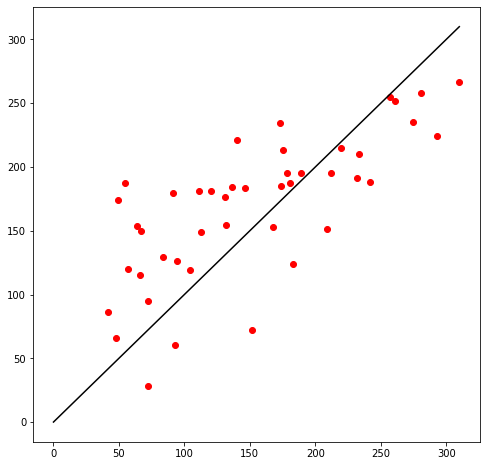

In [9]:
regressor = LinearRegression()
X_train = best_regr_Y.loc[:(N-(P+T)),:]
Y_train = df_norm_Y.loc[:(N-(P+T)), 'Y i']
regressor.fit(X_train, Y_train) # Se realiza la regresion
X_to_pron = best_regr_Y.loc[(N-P):, :] # X para el pronostico
Y_real = df.loc[(N-P):, 'Y'] # Y real para comparar con pronostico
Y_pred = inv_transf("i",regressor.predict(X_to_pron)) # Pronostico produccion
ecm = mean_squared_error(Y_real ,Y_pred) #ECM

print("ECM de pronostico", ecm)
plt.figure(figsize=(8, 8))
plt.plot(Y_real, Y_pred, 'bo',color='red')
plt.plot([0, max(Y_real)], [0, max(Y_real)], color='black')

## Modelo base
Debido a los anteriores cálculos el modelo base es: $Y = w_0 + w_1j(bmi) + w_2j(s4) + w_3j(bp) + w_4i(s6) + w_5j(sex) + w_6g(age) + w_7j(s3) + w_8i(s2) + w_9g(s1)$ 

## Modelo de redes neuronales
Para la asegurar la robustez del modelo se utilizará crossvalidation, se espera que para cierto número de neuronas en las capas ocultas exista un mínimo error de test.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit

In [13]:
max_hidden_layer_size = 5
X = best_regr_Y.loc[:(N-P),:] # El test se hace con el crossvalidation
Y = scaler(df_norm_Y.loc[:(N-P), 'Y i']) # El test se hace con el crossvalidation
cv = ShuffleSplit(n_splits=(N-P)//2, test_size=0.25, random_state=420) # Configuracion crossvalidation

# Seguarda la precision para las graficas
accuracy = np.zeros((5, 4))
best_score = 100000000000
best_mhl_1 = 0 # Mejor numero de neuronas en la capa oculta 1
best_mhl_2 = 0 # Mejor numero de neuronas en la capa 2

for mhl_1 in range(1, max_hidden_layer_size + 1):
  for mhl_2 in range(2, max_hidden_layer_size + 1):
    model = MLPRegressor(hidden_layer_sizes=(mhl_2, mhl_1 ),
         activation = 'logistic',
         learning_rate = 'adaptive',
         momentum = 0,
         learning_rate_init = 0.05,
         random_state = 45,
         max_iter = 100000
         )
    
    scores = -cross_val_score(model, X, Y, cv=cv, scoring='neg_mean_squared_error')
    mean = scores.mean()
    accuracy[mhl_1-1][mhl_2-2] = mean
    if (mean < best_score):
      best_score = mean
      best_mhl_1 = mhl_1
      best_mhl_2 = mhl_2

print("Mejor ECM", best_score, ", neuronas en la primer capa oculta", best_mhl_2, "y en la segunda", best_mhl_1)

Mejor ECM 0.02859487271092559 , neuronas en la primer capa oculta 3 y en la segunda 2


El error calculado muestra ser muy pequeño en comparación con los otros hallados en el modelo base. Se debe a que en el caso de la red neuronal se debe normalizar la variable de salida, por lo cual el $ECM$ arrojado no asegura una mejora tan significativa.

### Validacion del modelo de redes neuronales multicapa

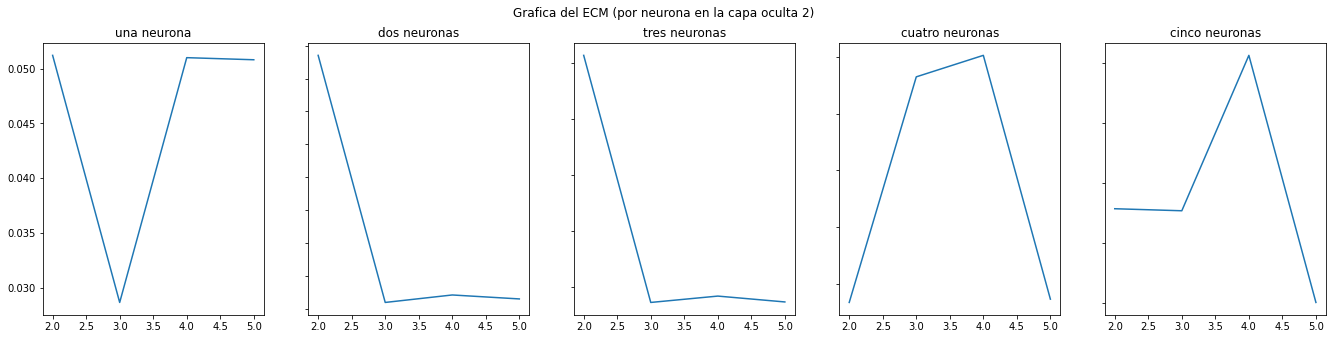

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(23,5))
xs = [2,3,4,5]
fig.suptitle('Grafica del ECM (por neurona en la capa oculta 2)')
ax1.plot(xs, accuracy[0])
ax2.plot(xs, accuracy[1])
ax3.plot(xs, accuracy[2])
ax4.plot(xs, accuracy[3])
ax5.plot(xs, accuracy[4])
ax1.title.set_text('una neurona')
ax2.title.set_text('dos neuronas')
ax3.title.set_text('tres neuronas')
ax4.title.set_text('cuatro neuronas')
ax5.title.set_text('cinco neuronas')
for ax in fig.get_axes():
    ax.label_outer()

Se puede observar que en el modelo con 3 neuronas en la primer capa oculta y 2 en la segunda tiene un $ECM$ que logra llegar al mínimo. Debido a esto, este modelo es el mejor. 

ECM de pronostico 2502.6554386650737


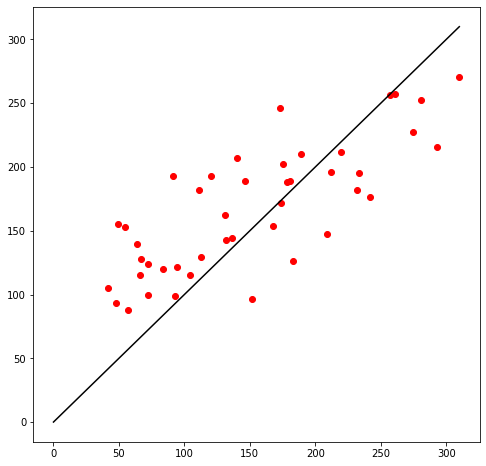

In [22]:
model = MLPRegressor(hidden_layer_sizes=(3, 2),
    activation = 'logistic',
    learning_rate = 'adaptive',
    momentum = 0,
    learning_rate_init = 0.05,
    random_state = 45,
    max_iter = 100000
    )

model.fit(X, Y)
Y_pred = inv_transf('i', des_scaler(model.predict(X_to_pron)))
ecm = mean_squared_error(Y_real ,Y_pred) #ECM

print("ECM de pronostico", ecm)
plt.figure(figsize=(8, 8))
plt.plot(Y_real, Y_pred, 'bo',color='red')
plt.plot([0, max(Y_real)], [0, max(Y_real)], color='black')

## Conclusión
Se puede notar una leve mejora del pronóstico por parte de la red neuronal multicapa en comparación con el modelo lineal. Para una mejor predicción de los datos se necesita un conjunto mucho más grande para el entrenamiento